## Imports

In [42]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Constants

In [43]:
HEADER_LEN = 6
KEEP = 1
COLORS = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
CURRENT_WORKING_DIR = os.getcwd()
print(CURRENT_WORKING_DIR)

#todo make dynamic
os.chdir('D:/Switchdrive/Uni/Thesis/code/HuberNicolas/MTDPolicy/')



CAT = {
    'usr': 'total-cpu-usage',
    'sys': 'total-cpu-usage',
    'idl': 'total-cpu-usage',
    'wai': 'total-cpu-usage',
    'hiq': 'total-cpu-usage',
    'siq': 'total-cpu-usage',

    'used' : 'memory usage',
    'buff' : 'memory usage',
    'cache' : 'memory usage',
    'free' : 'memory usage',

    'files': 'filesystem',
    'inodes' : 'fileystem',

    'read' : 'dsk/total',
    'writ' : 'dsk/total',
    'reads' : 'dsk/total',
    'writs' : 'dsk/total',

    'recv' : 'net/eth0',
    'send' : 'net/eth0',

    'lis' : 'tcp sockets',
    'act' : 'tcp sockets',
    'syn' : 'tcp sockets',
    'tim' : 'tcp sockets',
    'clo' : 'tcp sockets',

    'int' : 'system',
    'csw' : 'system',

    'run' : 'procs',
    'blk' : 'procs',
    'new' : 'procs'
}

CAT_NAMES = ['total-cpu-usage', 'memory-usage', 'filesystem', 'dsk-total1', 'dsk-total2', 'net-eth0', 'tcp sockets', 'system', 'procs',]

COL_NAMES = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]', 
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]', # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]', # / 1024 / 1024 = MB
    'cache: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]', # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]', # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',
    
    # net/eth0
    'recv: Amount of received bytes on eth0 [B]', # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections with status "listening" [#]', 
    'act: Number of TCP connections with status "established" (active) [#]',
    'syn: Number of TCP connections with status "syn_sent", "syn_receive" or "last_ack" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "fin-wait1/2", "close/_wait" or "closign" (closed) [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]', 
    'csw: Number of ontext switches [#]', 

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]', 
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]' 
]
PERIOD = 60

D:\Switchdrive\Uni\Thesis\code\HuberNicolas\MTDPolicy\data\csv


## Load csv files

### Loading

In [44]:
os.chdir('./data/csv')
healthy_files = glob.glob('healthy\*.csv')
infected_files = glob.glob('infected\*.csv')

# create dataframes for each .csv
dfs = []
header = None
for f in healthy_files:
    # create header
    if header is None:
        header = pd.read_csv(f, skiprows=HEADER_LEN)
        header = list(header.columns.values)
    # read and append
    dff = pd.read_csv(f, skiprows = HEADER_LEN + 1, header = None) # read csv
    dff = dff.iloc[:, :-1] # remove last row
    dff.columns = header # append header
    dfs.append(dff) # append to list of dfs
    
# append all dataframes dff to one dataframe df
df_healthy = pd.concat(dfs, ignore_index=True)


# create dataframes for each .csv
dfs = []
header = None
for f in infected_files:
    # create header
    if header is None:
        header = pd.read_csv(f, skiprows=HEADER_LEN)
        header = list(header.columns.values)
    # read and append
    dff = pd.read_csv(f, skiprows = HEADER_LEN + 1, header = None) # read csv
    #dff = dff.iloc[:, :-1] # remove last row
    dff.columns = header # append header
    dfs.append(dff) # append to list of dfs
    
# append all dataframes dff to one dataframe df
df_infected = pd.concat(dfs, ignore_index=True)

print(df_healthy)
print(df_infected)
#df_healthy.to_csv('healthy.csv', index=False, header=True)
#df_infected.to_csv('infected.csv', index=False, header=True)



# fix year
df_healthy['time'] = '2022-' + df_healthy['time'].astype(str)
df_healthy['time'] = pd.to_datetime(df_healthy['time'],format= '%Y-%d-%m %H:%M:%S')
# sort and reindex
df_healthy = df_healthy.sort_values(by='time')
df_healthy = df_healthy.iloc[::KEEP] # only take every KEEPth-entry
df_healthy = df_healthy.reset_index(drop=True)
df_healthy.set_index('time', inplace=True)

# fix year
df_infected['time'] = '2022-' + df_infected['time'].astype(str)
df_infected['time'] = pd.to_datetime(df_infected['time'],format= '%Y-%d-%m %H:%M:%S')
# sort and reindex
df_infected = df_infected.sort_values(by='time')
df_infected = df_infected.iloc[::KEEP] # only take every KEEPth-entry
df_infected = df_infected.reset_index(drop=True)
df_infected.set_index('time', inplace=True)


# save file
startDate = df_healthy.iloc[0].name.strftime('%Y-%m-%d')
startTime = df_healthy.iloc[0].name.strftime('%X')
endDate = df_healthy.iloc[-1].name.strftime('%Y-%m-%d')
endTime = df_healthy.iloc[-1].name.strftime('%X')
name = "{}-{}_{}-{}({}).csv".format(startDate.replace('-',''), startTime.replace(':',''), endDate.replace('-',''), endTime.replace(':',''), str(df_healthy.shape[0]))

df_healthy.to_csv('healthy.csv', index=True, header=True)

# save file
startDate = df_infected.iloc[0].name.strftime('%Y-%m-%d')
startTime = df_infected.iloc[0].name.strftime('%X')
endDate = df_infected.iloc[-1].name.strftime('%Y-%m-%d')
endTime = df_infected.iloc[-1].name.strftime('%X')
name = "{}-{}_{}-{}({}).csv".format(startDate.replace('-',''), startTime.replace(':',''), endDate.replace('-',''), endTime.replace(':',''), str(df_infected.shape[0]))

df_infected.to_csv('infected.csv', index=True, header=True)


                time     usr     sys     idl    wai  hiq    siq         used  \
0     15-07 19:17:08  17.192  29.207  53.450  0.049  0.0  0.103  996257792.0   
1     15-07 19:17:09   3.878  31.579  64.543  0.000  0.0  0.000  996651008.0   
2     15-07 19:17:10   2.671  33.234  64.095  0.000  0.0  0.000  996798464.0   
3     15-07 19:17:11   3.858  30.861  64.985  0.000  0.0  0.297  996798464.0   
4     15-07 19:17:12   7.099  26.852  66.049  0.000  0.0  0.000  996663296.0   
...              ...     ...     ...     ...    ...  ...    ...          ...   
1855  15-07 19:47:15   2.540  30.794  66.667  0.000  0.0  0.000  169504768.0   
1856  15-07 19:47:16   2.540  27.619  69.841  0.000  0.0  0.000  169095168.0   
1857  15-07 19:47:17   4.430  29.747  65.506  0.000  0.0  0.316  169246720.0   
1858  15-07 19:47:18   2.951  27.869  69.180  0.000  0.0  0.000  168472576.0   
1859  15-07 19:47:19   2.614  25.490  71.895  0.000  0.0  0.000  167866368.0   

            buff          cach  ...   l

<Figure size 5000x3600 with 0 Axes>

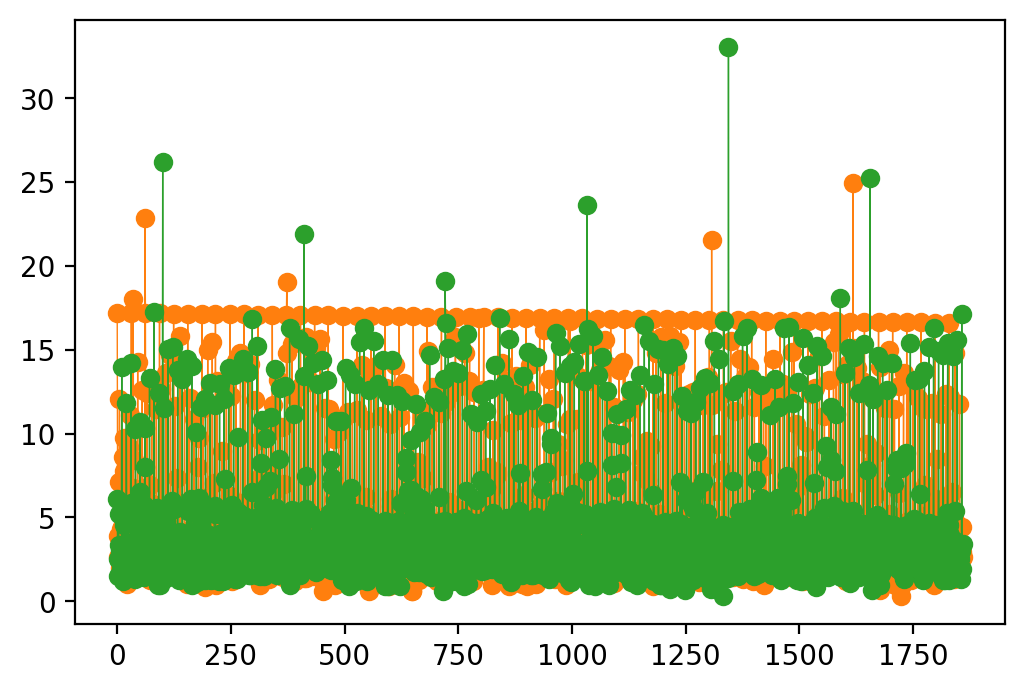

<Figure size 5000x3600 with 0 Axes>

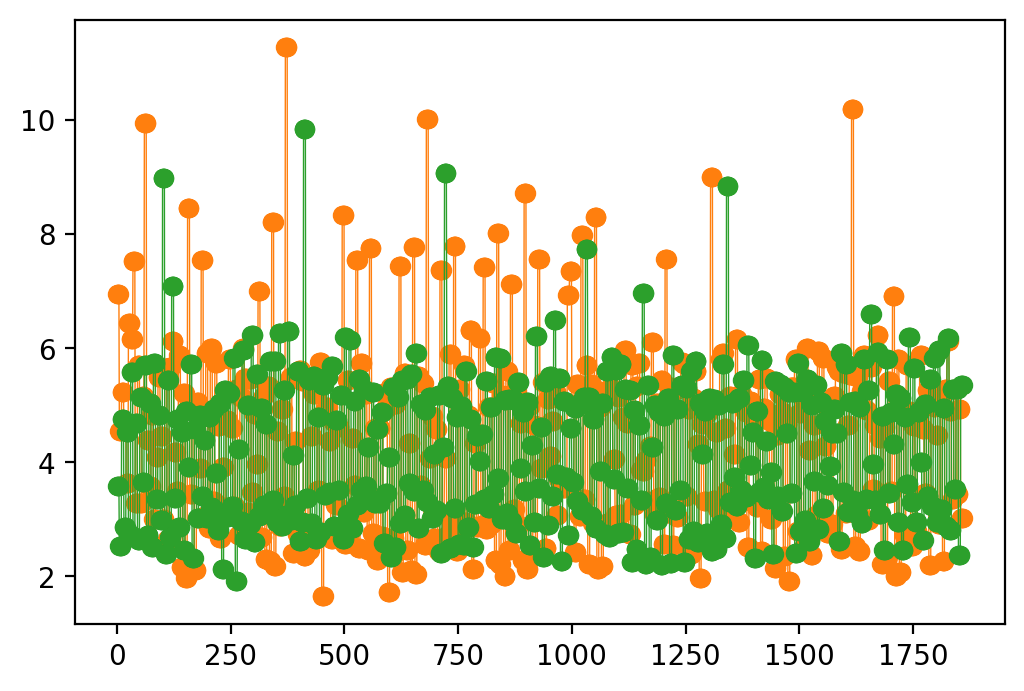

<Figure size 5000x3600 with 0 Axes>

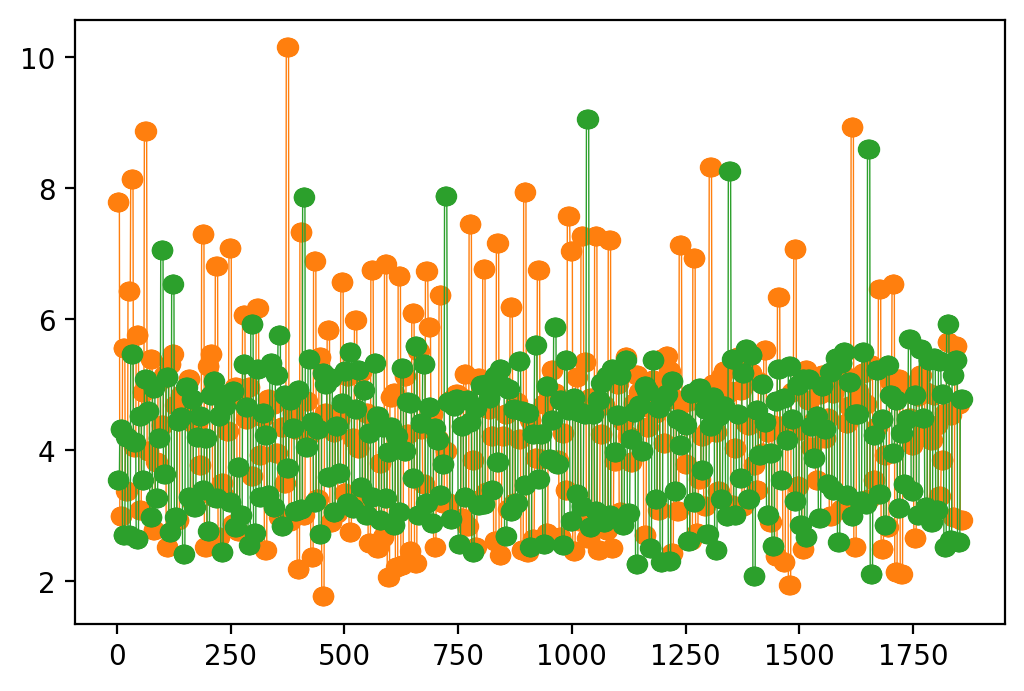

<Figure size 5000x3600 with 0 Axes>

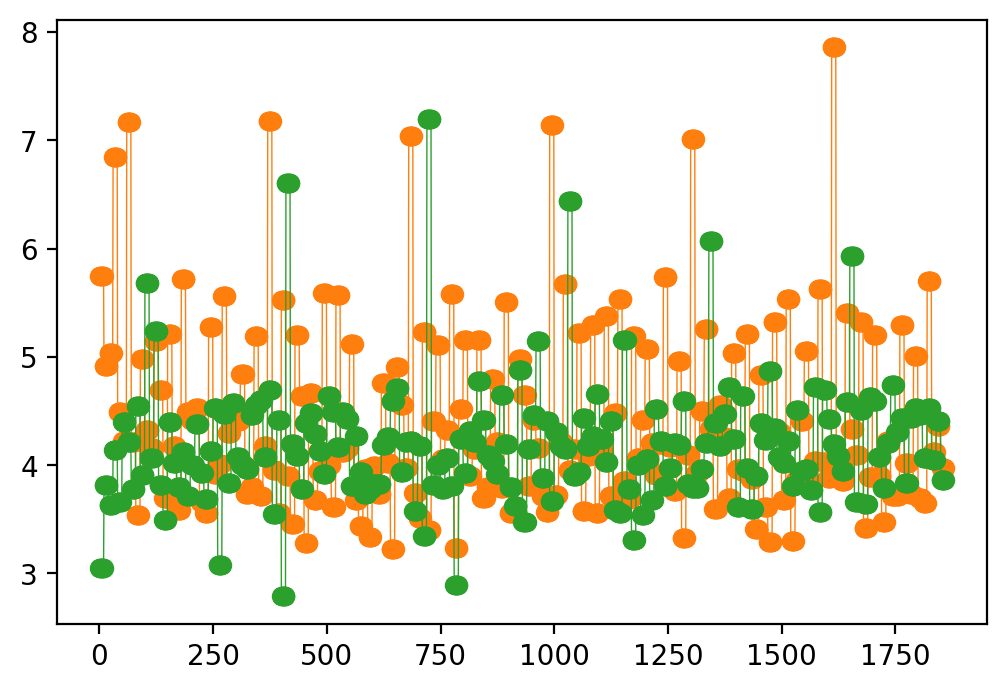

<Figure size 5000x3600 with 0 Axes>

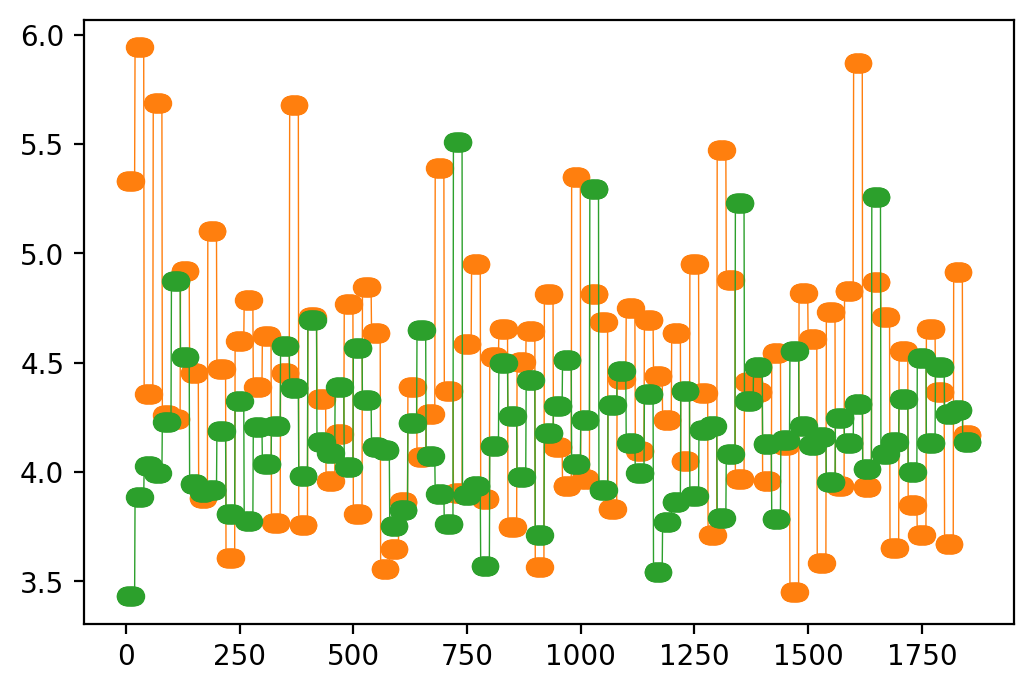

<Figure size 5000x3600 with 0 Axes>

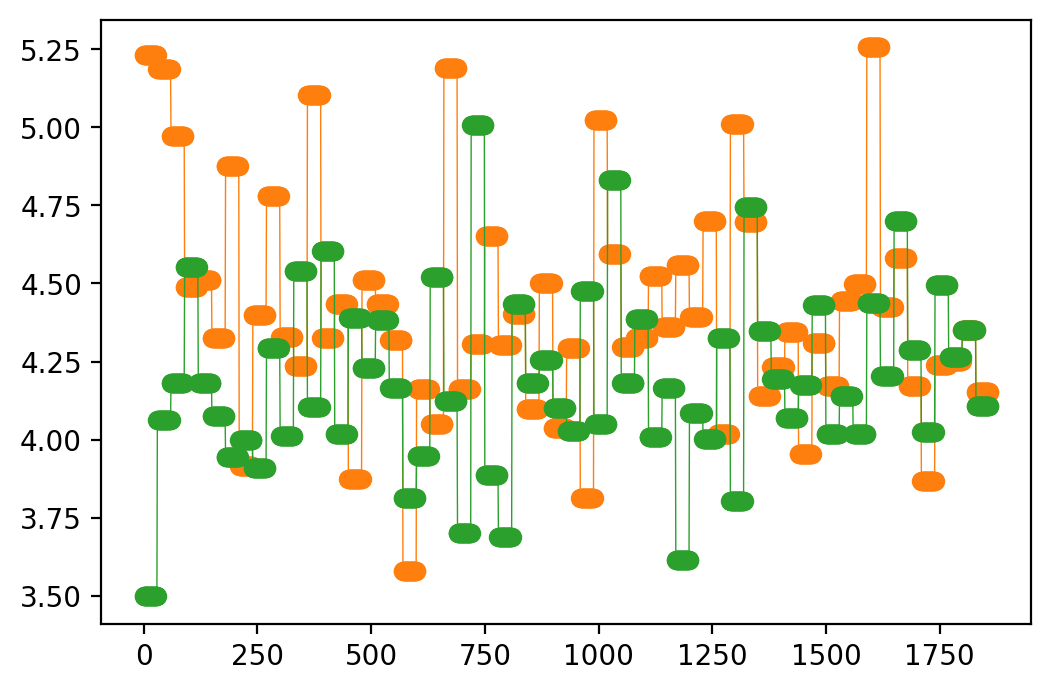

<Figure size 5000x3600 with 0 Axes>

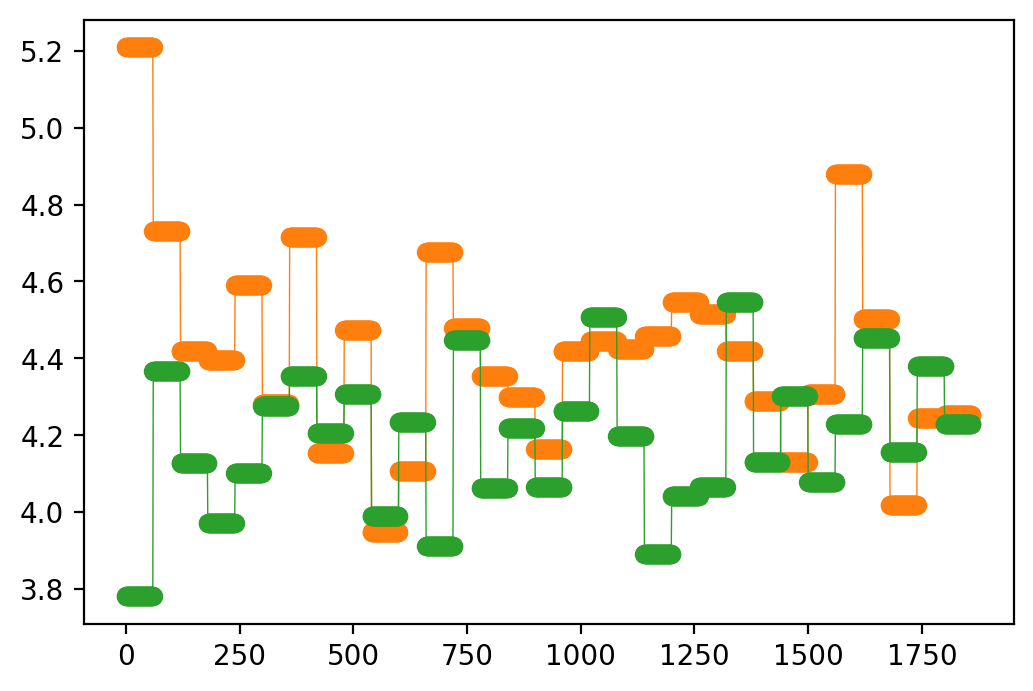

<Figure size 5000x3600 with 0 Axes>

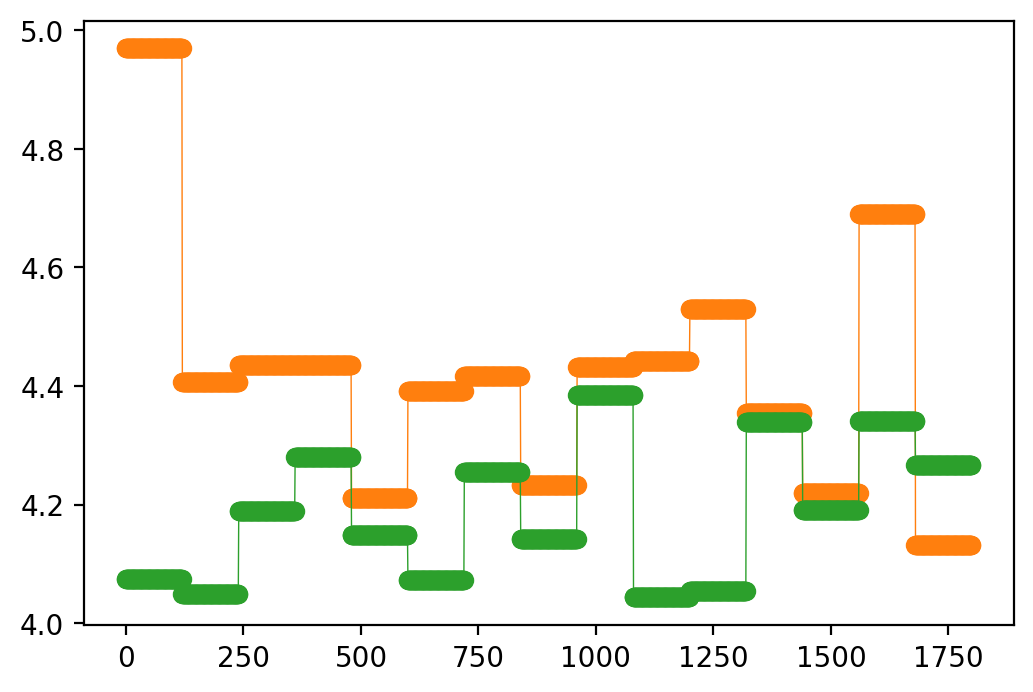

level_0
index
time
usr
sys
idl
wai
hiq
siq
used
buff
cach
free
files
inodes
read
writ
reads
writs
recv
send
lis
act
syn
tim
clo
int
csw
run
blk
new
usr-mean


In [50]:
WINDOWS = [1, 5, 6, 10, 20, 30, 60, 120]
# todo fix reset index
df_healthy.reset_index(inplace=True)
df_infected.reset_index(inplace=True)
for window in WINDOWS:
    df_healthy['usr-mean']  = df_healthy['usr'].rolling(window).mean()[window-1::window]
    df_healthy['usr-mean'].bfill(inplace = True)
    df_infected['usr-mean']  = df_infected['usr'].rolling(window).mean()[window-1::window]
    df_infected['usr-mean'].bfill(inplace = True)
    
    
    plt.figure(dpi=200)
    df_healthy['usr-mean'].plot(marker="o", color=COLORS[1], linestyle='-', linewidth=0.5)
    df_infected['usr-mean'].plot(marker="o", color=COLORS[2], linestyle='-', linewidth=0.5)  

    #plt.show()
plt.show()

